# Identify Peaks by Derivative

In [1]:
# For scan 3

In [2]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib
import re

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

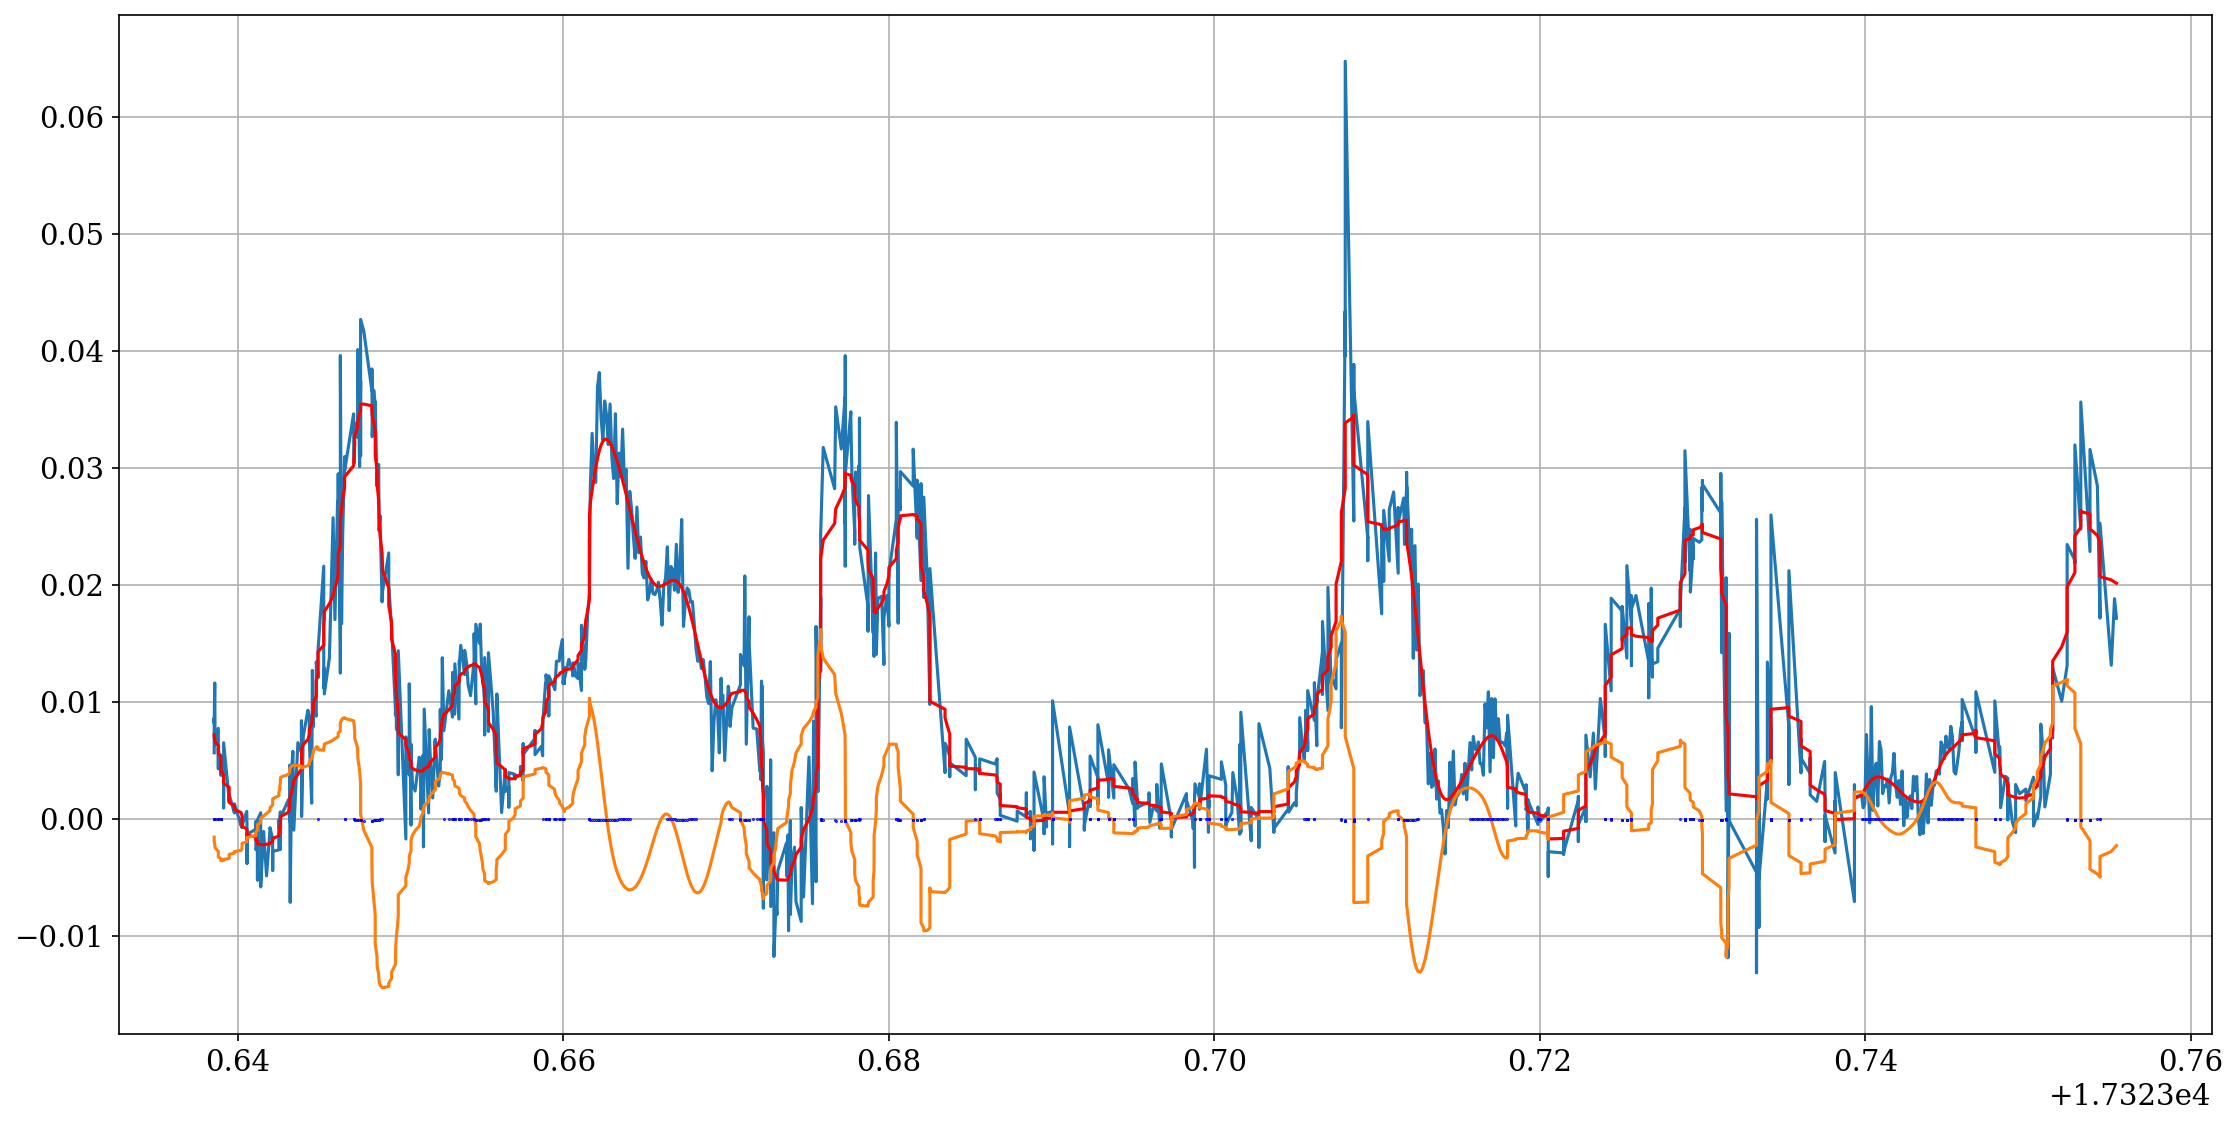

In [3]:
datafile = '20200423_scan3_background_corrected.csv'

k = np.genfromtxt(datafile, delimiter=',')[0:,0][:]
a_nosmooth = np.genfromtxt(datafile, delimiter=',')[0:,1][:]

# Smooth data, take derivative, smooth derivative, take derivative, smooth derivative

a = gaussian_filter1d(a_nosmooth, 5)

#a = savgol_filter(a_nosmooth, 33, 3)
da = gaussian_filter1d(np.gradient(a), 3)
#da = savgol_filter(da, 5, 1)
dda = gaussian_filter1d(np.gradient(da), 3)
#dda = savgol_filter(dda, 25, 3)

fig, ax = plt.subplots(figsize=(18, 9),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

ax.plot(k, a_nosmooth)
ax.plot(k, a, 'r-')
ax.plot(k, da*10, markersize=.5)
ax.plot(k[dda<0], dda[dda<0], 'bo', markersize=.4)
ax.grid(True)
plt.show()

[[2, 3, 4, 5, 6, 7, 8], [82], [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255], [729, 730, 731, 732, 733, 734, 735, 736]]


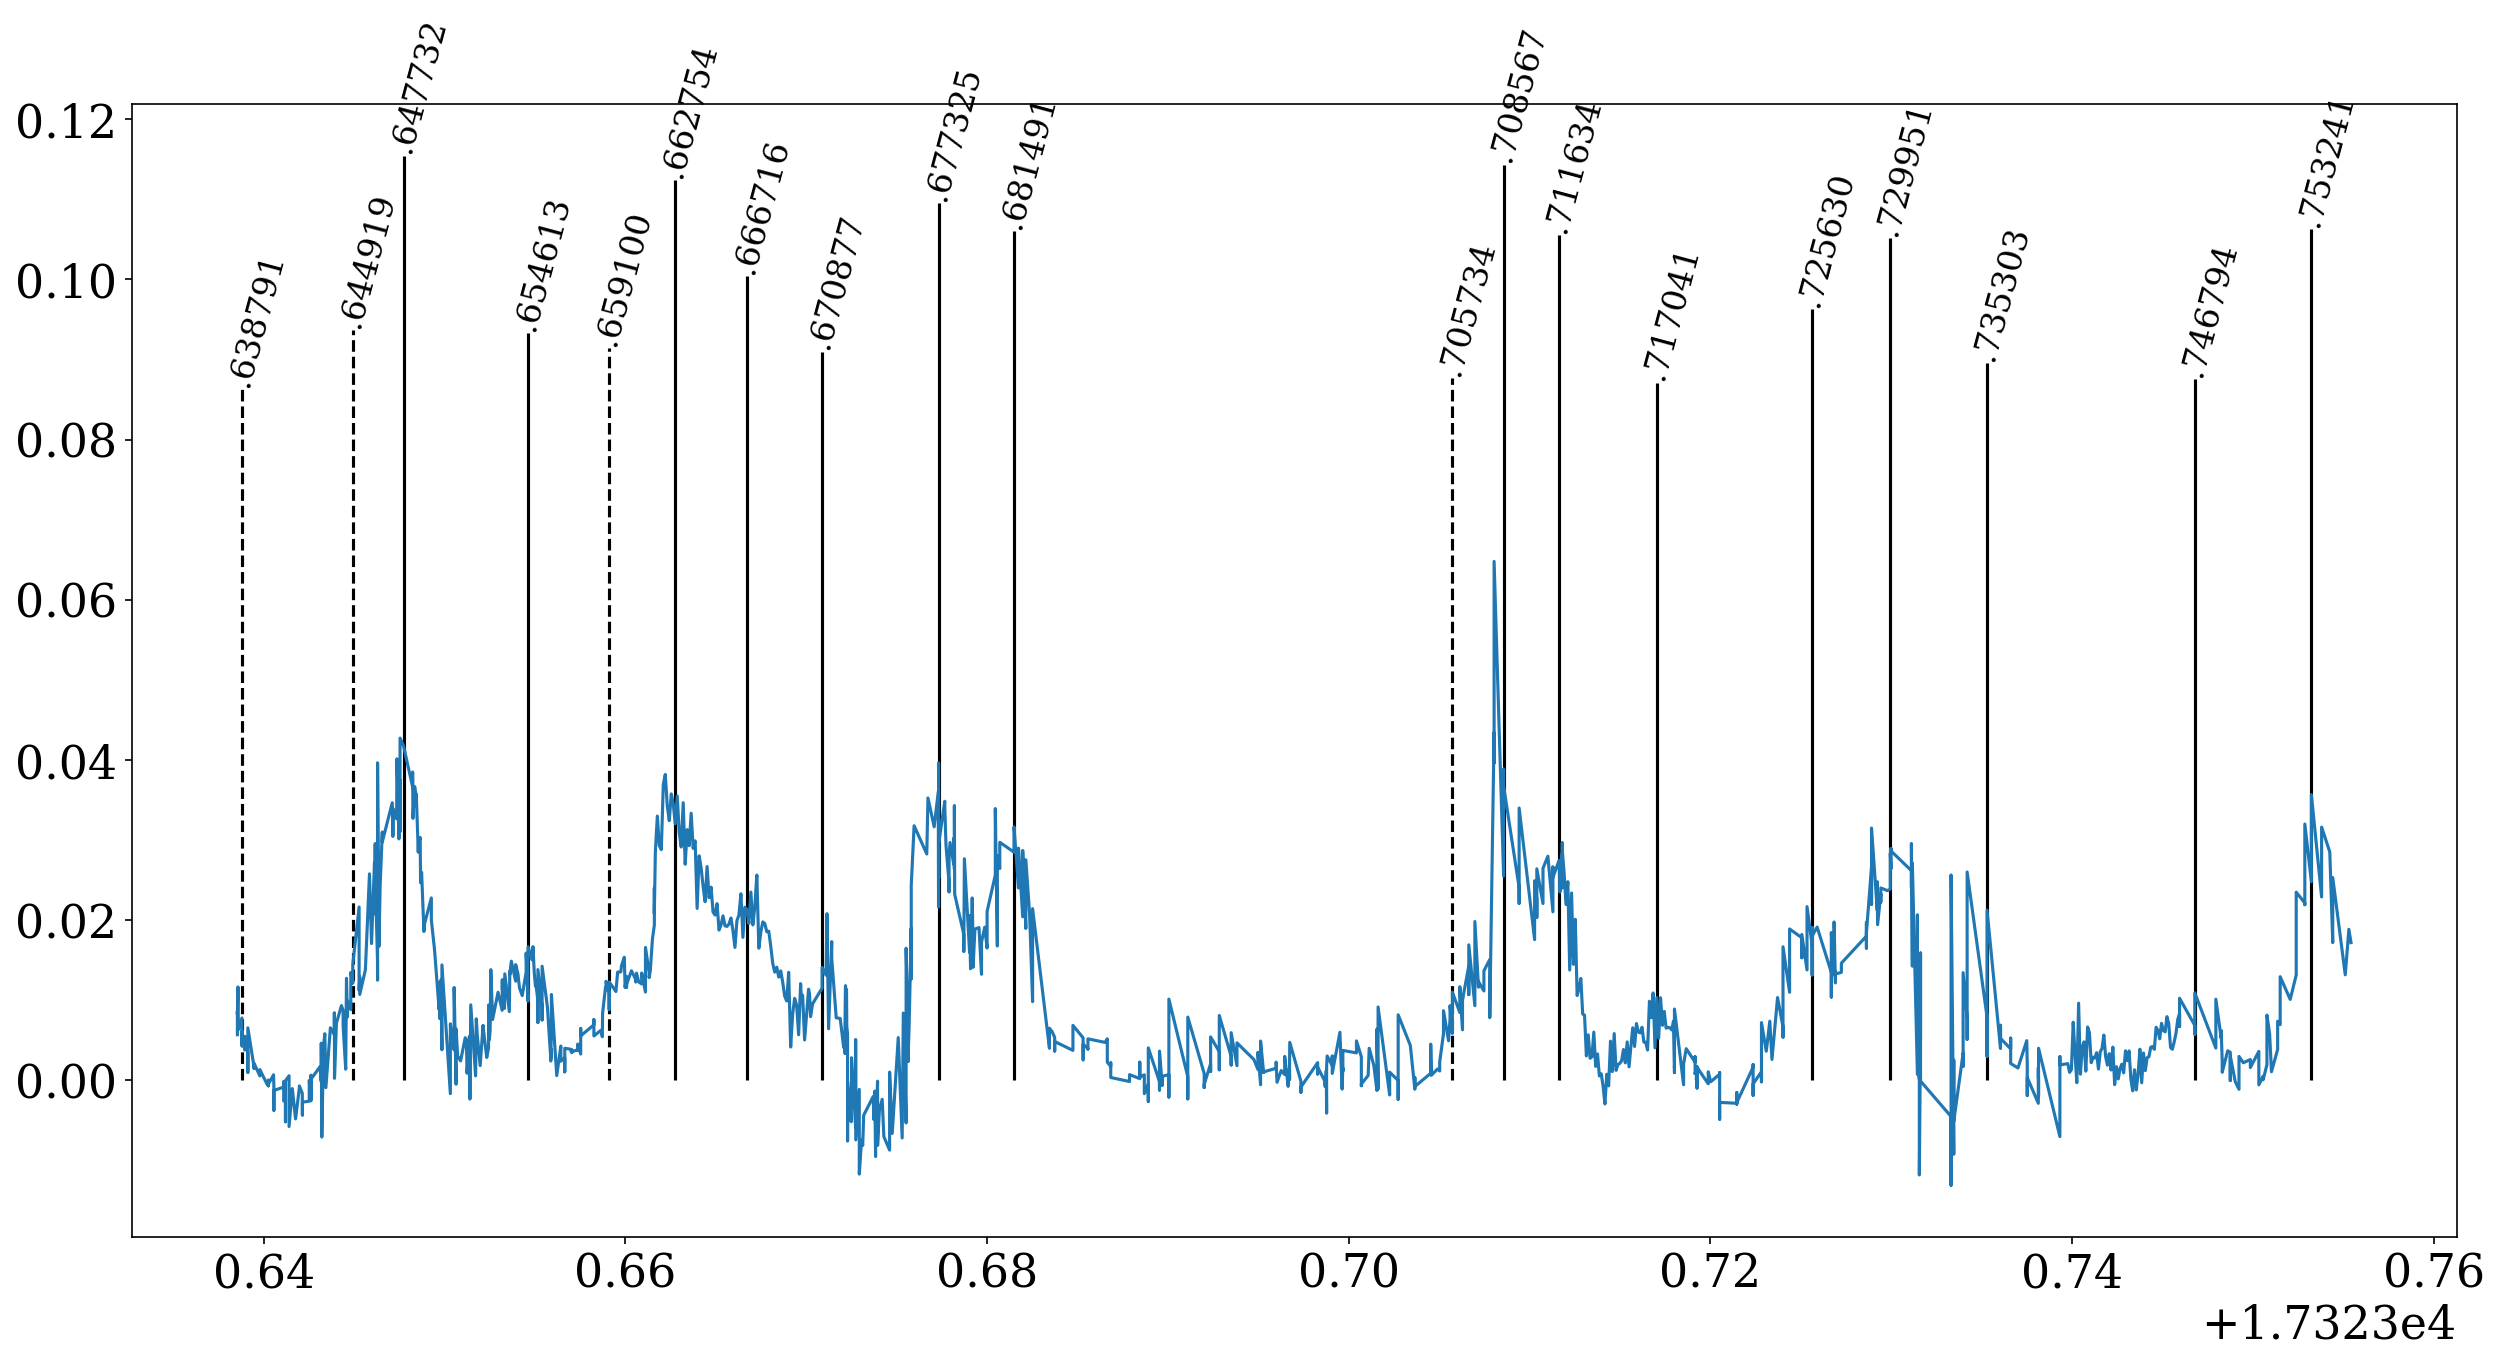

Line wavelengths: 0.647732236313459, 0.6546134768032061, 0.6627541280431615, 0.6667165131875663, 0.6708772869751556, 0.6773257513996214, 0.6814916834191536, 0.7085673011788458, 0.7116347265764489, 0.7170418507776049
Line widths: 0.0, 0.0, 0.0, 0.0


In [4]:
# Find peaks
threshold = .005 # Minimum height of peak
peaks1 = [] # Pretty sure there are peaks here (da goes from + to -)
peaks2 = [] # Not as sure there are peaks here (less sensitive condition: dda < 0)

for i in range(1, len(a)):
    if da[i-1]>0 and da[i]<0 and a[i]>threshold:
        peaks1.append(i)
    if dda[i] < 0 and a[i]>threshold:
        peaks2.append(i)
        
# Average nearby peak locations (could maybe get width from this) (only needed for peaks2)
runs = [[]]
for i in range(1,len(peaks2)):
    if peaks2[i] <= peaks2[i-1]+8:
        runs[-1].append(peaks2[i])
    else:
        runs.append([])
        runs[-1].append(peaks2[i])
        
# Remove runs containing a certain peak1
runs2 = []
for run in runs:
    if set(peaks1).isdisjoint(run) and not run in runs2:
        runs2.append(run)
runs = runs2

print(runs)

peaks2 = [int(mean(run)) for run in runs]
peaks = peaks1 + peaks2

peak_widths = [.5*len(run)*(k[1]-k[0]) for run in runs] #Some ill-defined measure of uncertainty/width. Currently not used

k_peaks1 = k[peaks1]
k_peaks2 = k[peaks2]
k_peaks = k[peaks]

# Plot location and values of lines
fig, ax = plt.subplots(figsize=(20, 10),dpi=150)
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'font.family': 'serif'})

h = .22
ax.plot(k, a_nosmooth)
for i in range(len(peaks1)):
    ax.vlines(k[peaks1[i]], 0, a[peaks1[i]]+.08)
    ax.text(k[peaks1[i]]-.001, 
            a[peaks1[i]]+.08, str(k[peaks1[i]]-int(k[0]))[1:8], 
            fontsize=16, rotation=75, va='bottom')
for i in range(len(peaks2)):
    ax.vlines(k[peaks2[i]], 0, a[peaks2[i]]+.08, linestyle='--')
    ax.text(k[peaks2[i]]-.001, 
            a[peaks2[i]]+.08, str(k[peaks2[i]]-int(k[0]))[1:8], 
            fontsize=16, rotation=75, va='bottom')
plt.show()

# Print the first 10 line to compare with Nick
print("Line wavelengths: " + ', '.join(map(str,k_peaks[:10]-int(k_peaks[0]))))
print("Line widths: " + ', '.join(map(str,peak_widths[:10])))  #Not used, should figure out how to do uncertainties

# Dataphile Fitting

In [11]:
# Generate model creator string
creator_string = ''

for i in peaks:
    creator_string += "Model(gaussian1D, Parameter(value={amplitude}, bounds=(.0001, .15),  label='amplitude'), Parameter(value={location}, bounds=(min(k)-.01, max(k)+.01), label='center'),Parameter(value=.0012,  bounds=(.0001, .01), label='width'), label='feature_{index}'),".format(location=k[i], amplitude=a[i], index=peaks.index(i))
creator_string += "label='gaussian_peaks')"
creator_string = "model = CompositeModel(" + creator_string


<IPython.core.display.Javascript object>


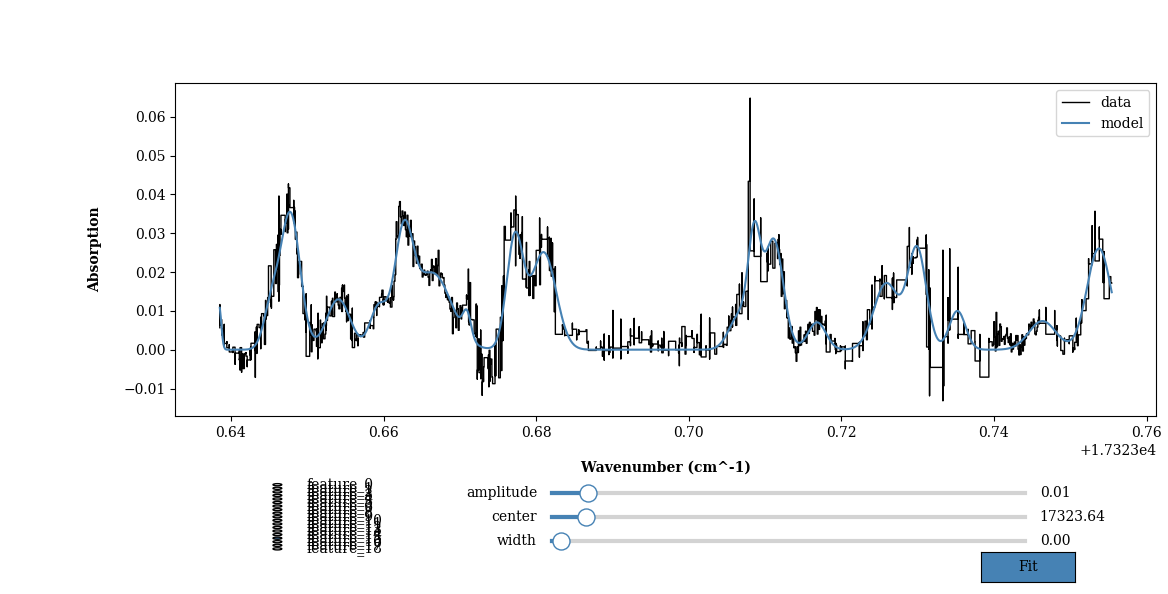

In [12]:
from dataphile.datasets import SyntheticDataset
from dataphile.statistics.distributions import gaussian1D, polynomial1D
from dataphile.statistics.regression.modeling import Parameter, Model, CompositeModel, AutoGUI
from matplotlib import patches
#plt.style.use('seaborn-notebook')
%matplotlib notebook

figure = plt.figure('Absorption Data', figsize=(9, 5))

# create main plot of data
ax_1 = figure.add_axes([0.15, 0.14, 0.84, 0.70])
data_graph, = ax_1.step(k, a_nosmooth, color='black', lw=1, label='data')

# labels
ax_1.set_ylabel('Absorption', labelpad=15, fontweight='semibold')
ax_1.set_xlabel('Wavenumber (cm^-1)', labelpad=15, fontweight='semibold')


# overlay small markers showing location of features
#loc, yloc = x0_s, [(bias + peak).max() + 25 for peak in peaks]
#markers = ax_2.scatter(xloc, yloc, marker='v', color='steelblue')

exec(creator_string)

xsample = np.linspace(min(k), max(k), 1000)
model_graph, = ax_1.plot(xsample, model(xsample), color='steelblue', label='model')
ax_1.legend();

ax_1.set_position([0.15, 0.30, 0.84, 0.56])
gui = AutoGUI(model, [model_graph], bbox=[0.20, 0.07, 0.75, 0.12], figure=figure,
              slider_options={'color': 'steelblue'}, data=(k, a));


In [13]:
model.summary()

value  uncertainty
model      parameter                           
feature_0  amplitude      0.035098     0.000739
           center     17323.647781     0.000097
           width          0.001289     0.000074
feature_1  amplitude      0.012969     0.000448
           center     17323.654083     0.000063
           width          0.001550     0.000074
feature_2  amplitude      0.026806     0.002334
           center     17323.662614     0.000057
           width          0.001205     0.000089
feature_3  amplitude      0.019697     0.000479
           center     17323.666409     0.000248
           width          0.002492     0.000255
feature_4  amplitude      0.006433     0.000993
           center     17323.670930     0.000093
           width          0.000537     0.000109
feature_5  amplitude      0.028522     0.000696
           center     17323.677214     0.000045
           width          0.001080     0.000032
feature_6  amplitude      0.025088     0.000508
           center     17323.680973     0.000061
           width          0.001629     0.000068
feature_7  amplitude      0.025997     0.004934
           center     17323.708594     0.000076
           width          0.000809     0.000086
feature_8  amplitude      0.028421     0.000571
           center     17323.711121     0.000075
           width          0.001256     0.000070
feature_9  amplitude      0.007054     0.000532
           center     17323.716811     0.000098
           width          0.001169     0.000105
feature_10 amplitude      0.017081     0.000439
           center     17323.725888     0.000086
           width          0.001630     0.000084
feature_11 amplitude      0.025892     0.000641
           center     17323.729916     0.000049
           width          0.001228     0.000052
feature_12 amplitude      0.009993     0.000733
           center     17323.735210     0.000065
           width          0.001056     0.000075
feature_13 amplitude      0.007386     0.000449
           center     17323.746351     0.000127
           width          0.001782     0.000128
feature_14 amplitude      0.026086     0.000478
           center     17323.753755     0.000051
           width          0.001577     0.000051
feature_15 amplitude      0.011480     0.006298
           center     17323.638440     0.000768
           width          0.000283     0.000681
feature_16 amplitude      0.010424     0.002229
           center     17323.645278     0.000224
           width          0.000991     0.000106
feature_17 amplitude      0.010808     0.000615
           center     17323.659347     0.000139
           width          0.001127     0.000114
feature_18 amplitude      0.008908     0.002202
           center     17323.706684     0.000725
           width          0.001366     0.000350

In [14]:
values0 = np.array([i.values for i in model.models])
uncerts0 = np.array([i.uncertainties for i in model.models])
#values = values0[uncerts0[:,0]/values0[:,0]<.1] # Only take models with fractional amplitude uncertainty < 10 %
#uncerts = uncerts0[uncerts0[:,0]/values0[:,0]<.1] # Could also just take the ones with amplitude above threshold

threshold = .003

values = values0[values0[:,0]>threshold]
uncerts = uncerts0[values0[:,0]>threshold]


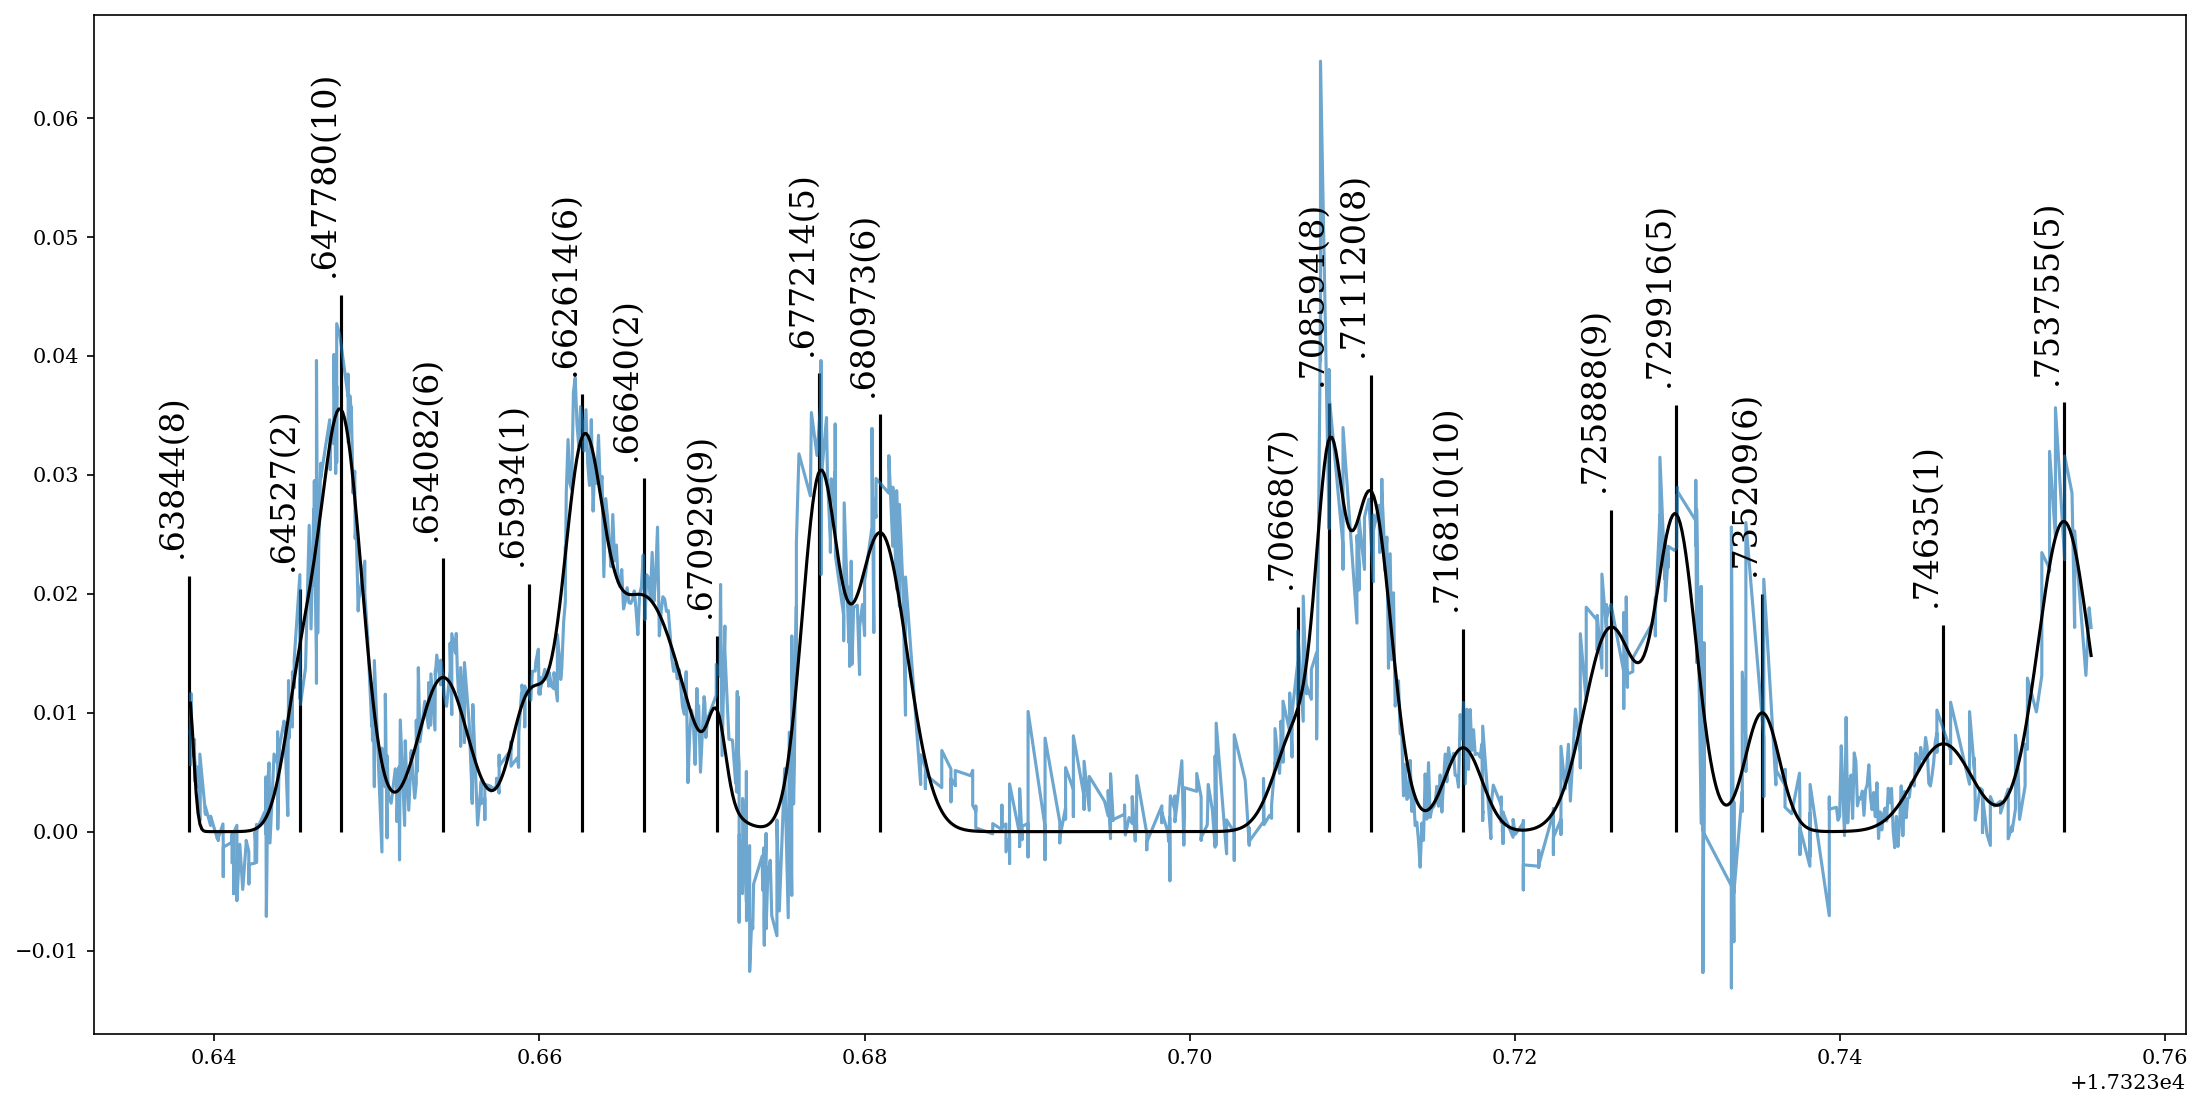

In [15]:
%matplotlib inline

amplitudes = values[0:,0]
k_peaks = values[0:,1]
d_k_peaks = uncerts[0:,1]


fig, ax = plt.subplots(figsize=(18, 9),dpi=150)


ax.plot(k, a_nosmooth, alpha=.65)
h = .01

# Plot location and values of lines
for i in range(len(k_peaks)):    
    ax.vlines(k_peaks[i], 0, amplitudes[i]+h)
    
    if 'e' in str(d_k_peaks[i]):
        n = int(str(d_k_peaks[i])[-1]) - 1
        
        if int(str(d_k_peaks[i])[2]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(d_k_peaks[i])[0]+')', 
                fontsize=16, rotation=90, va='bottom')
            
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(int(str(d_k_peaks[i])[0])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
    else:
        s = str(d_k_peaks[i])[2:]
        n = 0
        while s[0]=='0':
            s = s[1:]
            n += 1
            
        if int(str(d_k_peaks[i])[n+3]) < 5:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(d_k_peaks[i])[n+2]+')', 
                fontsize=16, rotation=90, va='bottom')
        else:
            ax.text(k_peaks[i]-.002, 
                amplitudes[i]+h*1.15, str(k_peaks[i]-int(k[0]))[1:n+4]+'('+str(int(str(d_k_peaks[i])[n+2])+1)+')', 
                fontsize=16, rotation=90, va='bottom')
            
model_graph, = ax.plot(xsample, model(xsample), color='black', label='model') #Plot fit
plt.show()